In [1]:
from brian2 import *
from brian2modelfitting import *
from torch import nn
import torch
import time

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# Model parameters
gL = 10*nS
EL = -70*mV
VT = -60.0*mV
C = 200*pF
ENa = 53*mV
EK = -107*mV
ground_truth_params = {'gNa': 30*uS, 'gK': 1*uS}
init_conds = {'Vm': 'EL',
              'm': '1/(1 + betam/alpham)',
              'h': '1/(1 + betah/alphah)',
              'n': '1/(1 + betan/alphan)'}

# Define a model with free 2 free parameters: gNa and gK
eqs = '''
     dVm/dt = -(gNa*m**3*h*(Vm - ENa) + gK*n**4*(Vm - EK) + gL*(Vm - EL) - I) / C : volt
     dm/dt = alpham*(1-m) - betam*m : 1
     dn/dt = alphan*(1-n) - betan*n : 1
     dh/dt = alphah*(1-h) - betah*h : 1

     alpham = (-0.32/mV) * (Vm - VT - 13.*mV) / (exp((-(Vm - VT - 13.*mV))/(4.*mV)) - 1)/ms : Hz
     betam = (0.28/mV) * (Vm - VT - 40.*mV) / (exp((Vm - VT - 40.*mV)/(5.*mV)) - 1)/ms : Hz
     alphah = 0.128 * exp(-(Vm - VT - 17.*mV) / (18.*mV))/ms : Hz
     betah = 4/(1 + exp((-(Vm - VT - 40.*mV)) / (5.*mV)))/ms : Hz
     alphan = (-0.032/mV) * (Vm - VT - 15.*mV) / (exp((-(Vm - VT - 15.*mV)) / (5.*mV)) - 1)/ms : Hz
     betan = 0.5*exp(-(Vm - VT - 10.*mV) / (40.*mV))/ms : Hz
     
     # The parameters to fit
     gNa : siemens (constant)
     gK : siemens (constant)
     '''

# Data traces have been generated from the simulator as defined in:
# https://github.com/brian-team/brian2/blob/master/examples/advanced/modelfitting_sbi.py#L33-L91
inp_trace = np.load('../data/input_traces_sim.npy')
out_trace = np.load('../data/output_traces_sim.npy')

# Set up time domain
dt = 0.05*ms
t = arange(0, out_trace.size*dt/ms, dt/ms)
t_start, t_end = t[np.where(inp_trace != 0)[0][[0, -1]]]

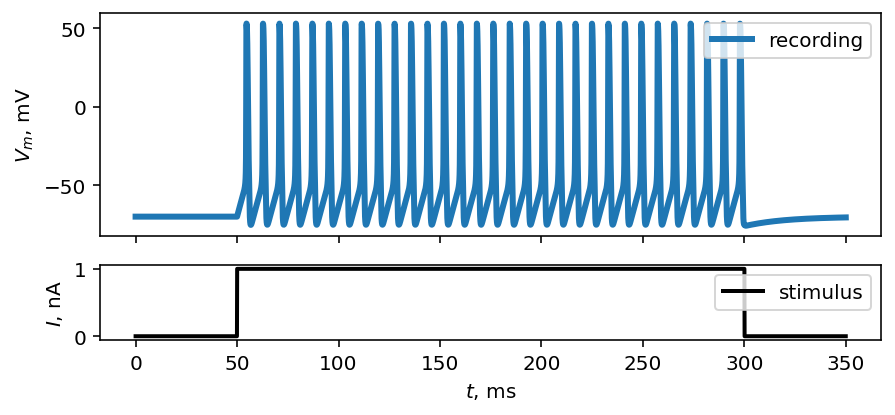

In [4]:
# Visualize the traces from which the free parameters will be inferred
fig, axs = subplots(2, 1, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 3))
axs[0].plot(t, out_trace, lw=3, label='recording')
axs[0].set_ylabel('$V_{m}$, mV')
axs[0].legend(loc='upper right')

axs[1].plot(t, inp_trace * 1e9, 'k-', lw=2, label='stimulus')
axs[1].set_xlabel('$t$, ms')
axs[1].set_ylabel('$I$, nA')
axs[1].legend(loc='upper right');

In [5]:
# Simulation-based inference object instantiation - no features are defined
inferencer = Inferencer(dt=dt, model=eqs,
                        input={'I': inp_trace.reshape(1, -1)*amp},
                        output={'Vm': out_trace.reshape(1, -1)*mV},
                        method='exponential_euler',
                        threshold='m>0.5', refractory='m>0.5',
                        param_init=init_conds)

In [6]:
# Supercool embedding net
class YuleNet(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=64,
                               stride=1, padding=32, bias=True)
        self.relu1 = nn.ReLU()
        pooling1 = 16
        self.pool1 = nn.AvgPool1d(kernel_size=pooling1)

        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=64,
                               stride=1, padding=32, bias=True)
        self.relu2 = nn.ReLU()
        pooling2 = int((in_features // pooling1) // 16)
        self.pool2 = nn.AvgPool1d(kernel_size=pooling2)

        self.dropout = nn.Dropout(p=0.50)

        self.linear = nn.Linear(#in_features=8 * in_features // (pooling1 * pooling2),
                                in_features=128,
                                out_features=out_features)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        if x.ndim == 1:
            x = x.view(1, 1, -1)
        else:
            x = x.view(len(x), 1, -1)
        x_conv1 = self.conv1(x)
        x_relu1 = self.relu1(x_conv1)
        x_pool1 = self.pool1(x_relu1)

        x_conv2 = self.conv2(x_pool1)
        x_relu2 = self.relu2(x_conv2)
        x_pool2 = self.pool2(x_relu2)
        
        x_flatten = x_pool2.view(len(x), 1, -1)
        x_dropout = self.dropout(x_flatten)

        x = self.relu3(self.linear(x_dropout))
        return x.view(len(x), -1)

In [14]:
# It is enough to pass a instantiated embedding network to Inferencer
start_time = time.time()
posterior_gpu = inferencer.infer(n_samples=10_000, n_rounds=2,
                                 inference_method='SNPE',
                                 density_estimator_model='mdn',
                                 inference_kwargs={'embedding_net': YuleNet(out_trace.size, 8)},
                                 train_kwargs={#'max_num_epochs': 30, 
                                               'num_atoms': 10,
                                               'training_batch_size': 128,
                                               'use_combined_loss': True,
                                               'discard_prior_samples': True},
                                 device='gpu',
                                 restart=True,
                                 gNa=[.5*uS, 80.*uS],
                                 gK=[1e-4*uS, 15.*uS])
end_time = time.time()

Aranging output traces:   0%|          | 0/1 [00:00<?, ?it/s]

2-round focused inference:   0%|          | 0/2 [00:00<?, ?it/s]

Neural network successfully converged after 66 epochs.
Neural network successfully converged after 21 epochs.


In [15]:
print(f'Elapsed training time (GPU): {end_time - start_time:.4f}s')

Elapsed training time (GPU): 354.0382s


In [16]:
# Draw a ton of samples
samples = inferencer.sample((10_000, ))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

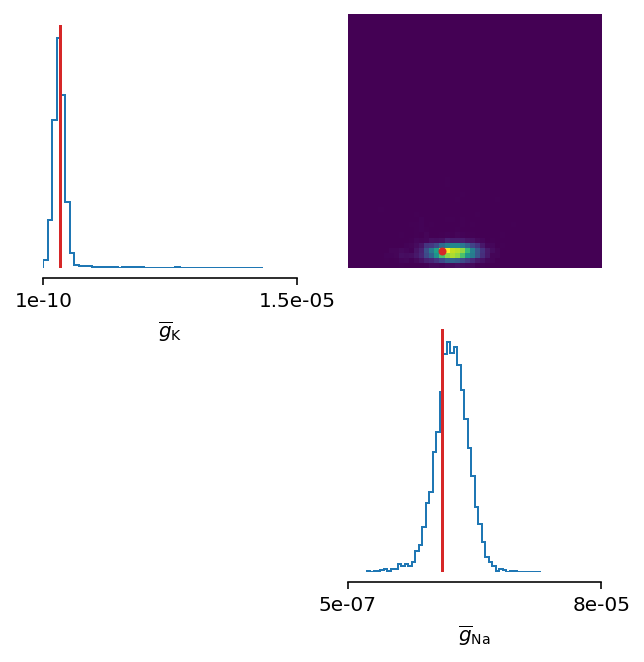

In [17]:
# And visualize sampled posterior
limits = {'gNa': [.5*uS, 80.*uS], 'gK': [1e-4*uS, 15.*uS]}
inferencer.pairplot(limits=limits,
                    ticks=limits,
                    labels={'gNa': r'$\overline{g}_\mathrm{Na}$',
                            'gK': r'$\overline{g}_\mathrm{K}$'},
                    points=ground_truth_params,
                    points_offdiag={'markersize': 6},
                    points_colors = ['C3'],
                    figsize=(5, 5));

In [18]:
# Let's now generate the fitted trace using a single sample from posterior
inf_trace = inferencer.generate_traces()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

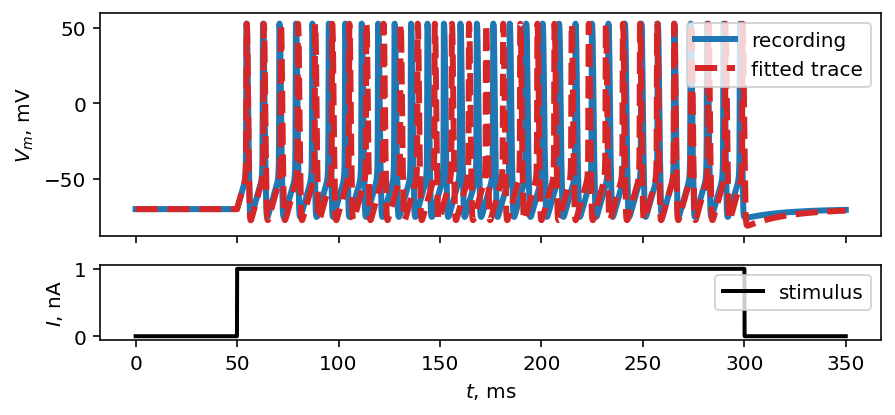

In [19]:
# And let's visualize traces
fig, axs = subplots(2, 1, sharex=True,
                    gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 3))
axs[0].plot(t, out_trace.ravel(), lw=3, label='recording')
axs[0].plot(t, inf_trace.ravel()/mV, 'C3--', lw=3, label='fitted trace')
axs[0].set_ylabel('$V_{m}$, mV')
axs[0].legend(loc='upper right')

axs[1].plot(t, inp_trace.ravel() * 1e9, 'k-', lw=2, label='stimulus')
axs[1].set_xlabel('$t$, ms')
axs[1].set_ylabel('$I$, nA')
axs[1].legend(loc='upper right');